# Лабораторна робота №2 — Класифікація (Part 1 + Part 2)

**Студентка:** Olena Mykhailovska  
**Група:** CS-31  
**NO:** 13 (STUDENT_ID = 13)

Зміст:
- Part 1 — експерименти на штучно згенерованих даних (спіраль, Gaussian, 'funky' — кола + кластери).  
- Part 2 — аналіз та класифікація реального датасету `nasa.csv` (передобробка, модельна селекція, grid search, оцінка).  

Усі ключові кроки: підготовка даних → тренування моделей → метрики → візуалізації (PCA для візуалізації меж класифікатора).


In [1]:
# Імпорти й базові налаштування
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA

# Класифікатори
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

# Встановлюємо seed по STUDENT_ID
STUDENT_ID = 13
np.random.seed(STUDENT_ID)

# Налаштування візуалізації
plt.rcParams.update({'figure.figsize': (7,7)})


## Part 1 — Інструменти для штучних даних

Нижче — набор функцій:
- kernel-генератори: gaussian_kernel, circle_kernel, spiral_kernel, sine_wave_kernel, exponential_kernel
- generate_classification_data(...) — гнучка функція, що комбінує ядра й додає шум/аутлайєри
- plot_classifier_boundary(...) та plot_classifier_boundary_by_dots(...) — два варіанти візуалізації меж (перший — сітка, другий — фонова вибірка точок)
- show_classification_report(...) — основні метрики + матриця плутанини


In [2]:
# -----------------------
# Kernel-фабрики
# -----------------------
def gaussian_kernel(center):
    '''Повертає функцію, що генерує n точок навколо center.'''
    return lambda n: np.repeat(np.array([center]), n, axis=0)

def circle_kernel(radius, start_angle=0, end_angle=2 * np.pi):
    def _kernel(n):
        theta = np.linspace(start_angle, end_angle, n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T
    return _kernel

def spiral_kernel(rotations=1.5, start_radius=1.0):
    def _kernel(n):
        theta = np.linspace(0, rotations * 2 * np.pi, n)
        radius = np.linspace(start_radius, start_radius + (rotations * 2), n)
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        return np.vstack([x, y]).T
    return _kernel

def sine_wave_kernel(amplitude=1, frequency=1, x_range=(-5, 5)):
    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * np.sin(frequency * x)
        return np.vstack([x, y]).T
    return _kernel

def exponential_kernel(amplitude=1, base=np.e, x_range=(-2, 2)):
    def _kernel(n):
        x = np.linspace(x_range[0], x_range[1], n)
        y = amplitude * (base ** x)
        return np.vstack([x, y]).T
    return _kernel

# -----------------------
# Генератор даних
# -----------------------
def generate_classification_data(n_samples=200, kernels=None, kernel_classes=None,
                                 dispersion=0.2, n_outliers=10, random_seed=42):
    '''
    Генерує 2D дані, комбінуючи ядра.
    Повертає X (n_samples,2) та y (n_samples,).
    '''
    np.random.seed(random_seed)

    if kernels is None:
        kernels = [gaussian_kernel(center=[2, 2]), gaussian_kernel(center=[-2, -2])]
    if kernel_classes is None:
        kernel_classes = list(range(len(kernels)))
    if len(kernels) != len(kernel_classes):
        raise ValueError("len(kernels) must equal len(kernel_classes)")

    n_classes = len(np.unique(kernel_classes))
    n_inliers = n_samples - n_outliers
    if n_inliers <= 0:
        raise ValueError("n_samples must be greater than n_outliers")

    points_per_kernel = n_inliers // len(kernels)
    X_parts, y_parts = [], []
    for i, kernel in enumerate(kernels):
        class_label = kernel_classes[i]
        # переконання, що вихід float
        X_class = kernel(points_per_kernel).astype(float)
        X_class += np.random.randn(points_per_kernel, 2) * dispersion
        y_class = np.full(points_per_kernel, class_label)
        X_parts.append(X_class)
        y_parts.append(y_class)

    X_inliers = np.vstack(X_parts)
    y_inliers = np.hstack(y_parts)

    if n_outliers > 0:
        x_min, x_max = X_inliers[:, 0].min(), X_inliers[:, 0].max()
        y_min, y_max = X_inliers[:, 1].min(), X_inliers[:, 1].max()
        padding = (max(x_max - x_min, y_max - y_min)) * 0.1
        X_outliers = np.random.uniform(min(x_min, y_min) - padding,
                                       max(x_max, y_max) + padding,
                                       size=(n_outliers, 2))
        y_outliers = np.random.randint(0, n_classes, size=n_outliers)
        X = np.vstack([X_inliers, X_outliers])
        y = np.hstack([y_inliers, y_outliers])
    else:
        X, y = X_inliers, y_inliers

    permutation = np.random.permutation(X.shape[0])
    return X[permutation], y[permutation]

# -----------------------
# Візуалізації і звіти
# -----------------------
def plot_classifier_boundary(X, y, model=None, resolution=200, title=None):
    '''
    Контурна візуалізація меж. Якщо model is None — просто scatter.
    '''
    fig, ax = plt.subplots(figsize=(7,7))
    if model is not None:
        x1_min, x1_max = X[:,0].min(), X[:,0].max()
        x2_min, x2_max = X[:,1].min(), X[:,1].max()
        x1_pad = (x1_max - x1_min) * 0.2
        x2_pad = (x2_max - x2_min) * 0.2
        plot_x1_min, plot_x1_max = x1_min - x1_pad, x1_max + x1_pad
        plot_x2_min, plot_x2_max = x2_min - x2_pad, x2_max + x2_pad

        xx1, xx2 = np.meshgrid(np.linspace(plot_x1_min, plot_x1_max, resolution),
                               np.linspace(plot_x2_min, plot_x2_max, resolution))
        grid = np.c_[xx1.ravel(), xx2.ravel()]
        try:
            Z = model.predict(grid).reshape(xx1.shape)
            ax.contourf(xx1, xx2, Z, alpha=0.3)
            ax.set_xlim(plot_x1_min, plot_x1_max)
            ax.set_ylim(plot_x2_min, plot_x2_max)
        except Exception:
            pass

    scatter = ax.scatter(X[:,0], X[:,1], c=y, edgecolor='k', s=40)
    ax.set_title(title or 'Decision boundary / Data scatter')
    plt.show()

def plot_classifier_boundary_by_dots(X, y, model=None, n_background_points=10000, title=None):
    '''
    Візуалізація з фоновою випадковою вибіркою точок.
    '''
    fig, ax = plt.subplots(figsize=(7,7))
    if model is not None:
        x1_min, x1_max = X[:,0].min(), X[:,0].max()
        x2_min, x2_max = X[:,1].min(), X[:,1].max()
        x1_pad = (x1_max - x1_min) * 0.1
        x2_pad = (x2_max - x2_min) * 0.1
        low = [x1_min - x1_pad, x2_min - x2_pad]
        high = [x1_max + x1_pad, x2_max + x2_pad]
        X_bg = np.random.uniform(low=low, high=high, size=(n_background_points, 2))
        try:
            preds = model.predict(X_bg)
            ax.scatter(X_bg[:,0], X_bg[:,1], c=preds, alpha=0.2, s=10, zorder=0)
        except Exception:
            pass

    ax.scatter(X[:,0], X[:,1], c=y, edgecolor='k', s=40, zorder=2)
    ax.set_title(title or 'Data scatter (dots)')
    plt.show()

def show_classification_report(X, y_true, model, title='Classification Performance'):
    y_pred = model.predict(X)
    n_classes = len(np.unique(y_true))
    print(f'----- 📊 {title} -----')
    print('Accuracy:', f'{accuracy_score(y_true,y_pred):.4f}')
    avg = 'weighted' if n_classes>2 else 'binary'
    print('Precision:', f'{precision_score(y_true,y_pred,average=avg, zero_division=0):.4f}')
    print('Recall:', f'{recall_score(y_true,y_pred,average=avg, zero_division=0):.4f}')
    print('F1-score:', f'{f1_score(y_true,y_pred,average=avg, zero_division=0):.4f}')
    print('-'*40)
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion matrix:')
    print(cm)


### Part 1 — Проведіть мінімум 3 експерименти на кожній моделі
1. Spiral data → SVC (міняємо C і gamma).  
2. Gaussian dots → LogisticRegression (міняємо C).  
3. Funky (circle + гаусіани) → RandomForest (міняємо n_estimators, max_depth).  

У кожному експерименті: тренування на повному згенерованому наборі (для інтуїції), вивід метрик на тих же даних (для розуміння поведінки), візуалізація меж (PCA-необов'язково — але тут робимо 2D прямо).



SVC Spiral: C=0.1, gamma=scale
----- 📊 SVC Spiral (C=0.1, gamma=scale) -----
Accuracy: 0.5750
Precision: 0.5708
Recall: 0.6050
F1-score: 0.5874
----------------------------------------
Confusion matrix:
[[109  91]
 [ 79 121]]


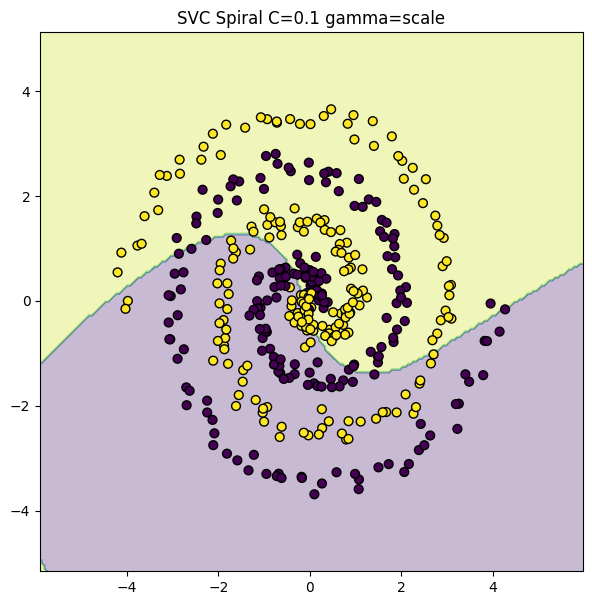


SVC Spiral: C=1, gamma=scale
----- 📊 SVC Spiral (C=1, gamma=scale) -----
Accuracy: 0.6525
Precision: 0.6564
Recall: 0.6400
F1-score: 0.6481
----------------------------------------
Confusion matrix:
[[133  67]
 [ 72 128]]


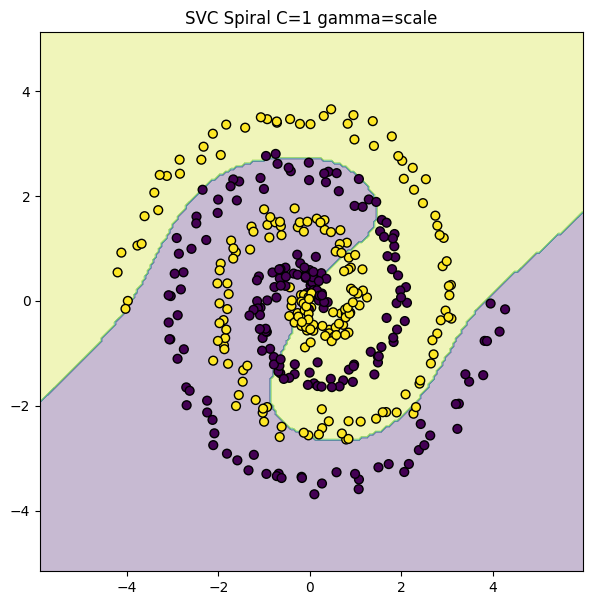


SVC Spiral: C=10, gamma=0.1
----- 📊 SVC Spiral (C=10, gamma=0.1) -----
Accuracy: 0.6900
Precision: 0.7043
Recall: 0.6550
F1-score: 0.6788
----------------------------------------
Confusion matrix:
[[145  55]
 [ 69 131]]


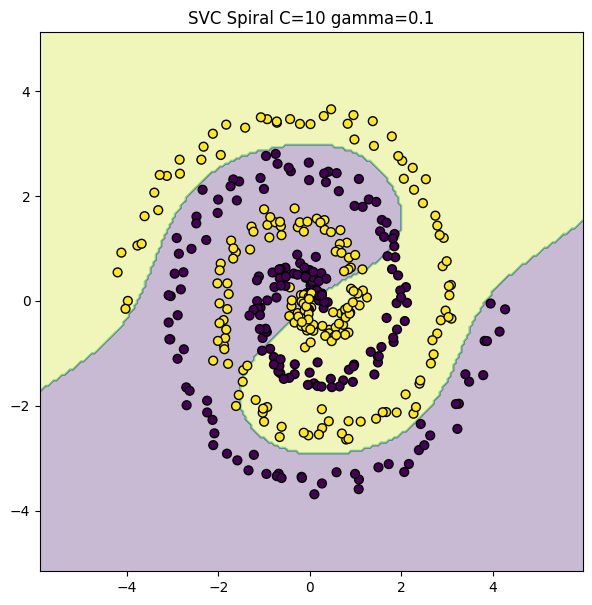


LogReg Gaussian: C=0.01
----- 📊 LogReg Gaussian (C=0.01) -----
Accuracy: 0.9699
Precision: 0.9652
Recall: 0.9898
F1-score: 0.9773
----------------------------------------
Confusion matrix:
[[ 96   7]
 [  2 194]]


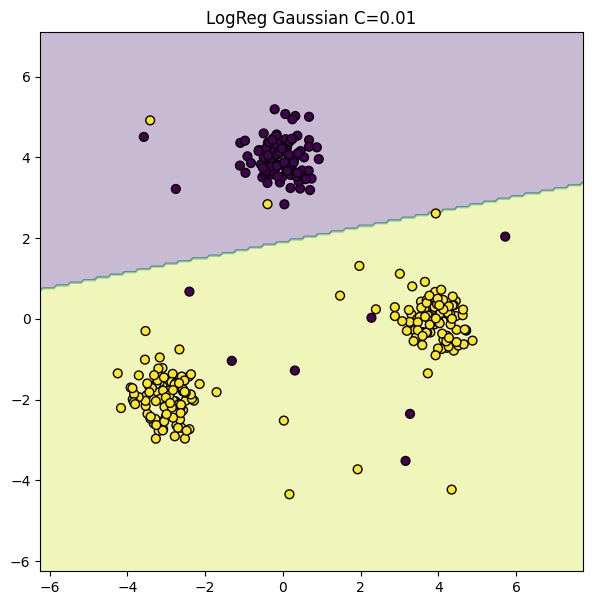


LogReg Gaussian: C=1
----- 📊 LogReg Gaussian (C=1) -----
Accuracy: 0.9666
Precision: 0.9650
Recall: 0.9847
F1-score: 0.9747
----------------------------------------
Confusion matrix:
[[ 96   7]
 [  3 193]]


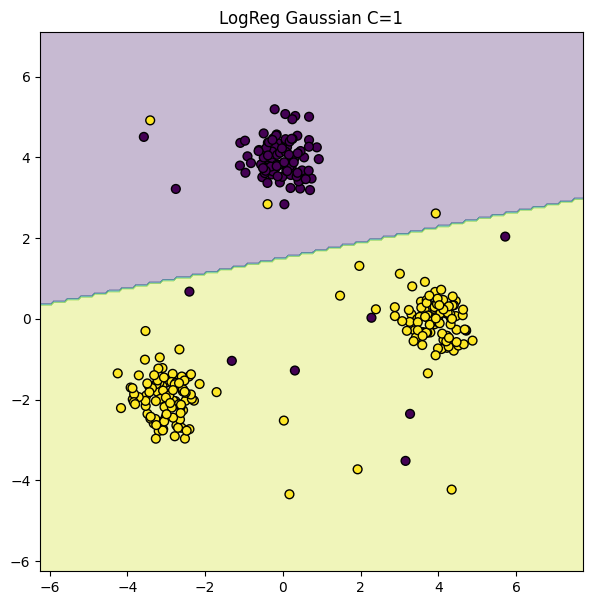


LogReg Gaussian: C=100
----- 📊 LogReg Gaussian (C=100) -----
Accuracy: 0.9666
Precision: 0.9650
Recall: 0.9847
F1-score: 0.9747
----------------------------------------
Confusion matrix:
[[ 96   7]
 [  3 193]]


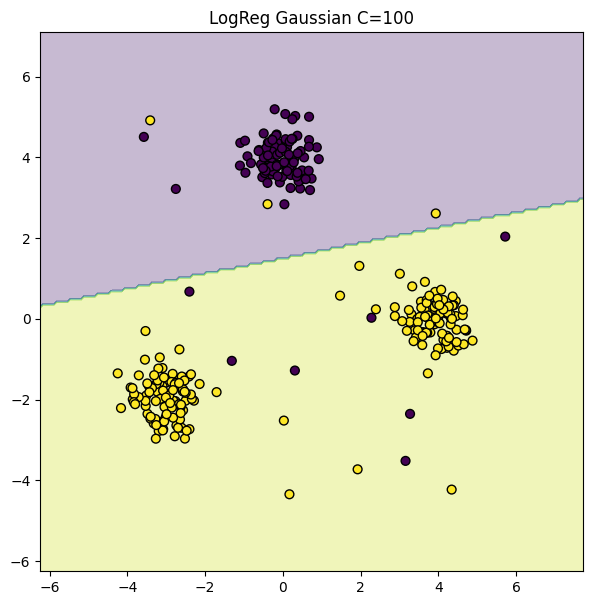


RandomForest Funky: n_estimators=10
----- 📊 RF Funky (n_estimators=10) -----
Accuracy: 0.9933
Precision: 1.0000
Recall: 0.9909
F1-score: 0.9954
----------------------------------------
Confusion matrix:
[[ 79   0]
 [  2 218]]


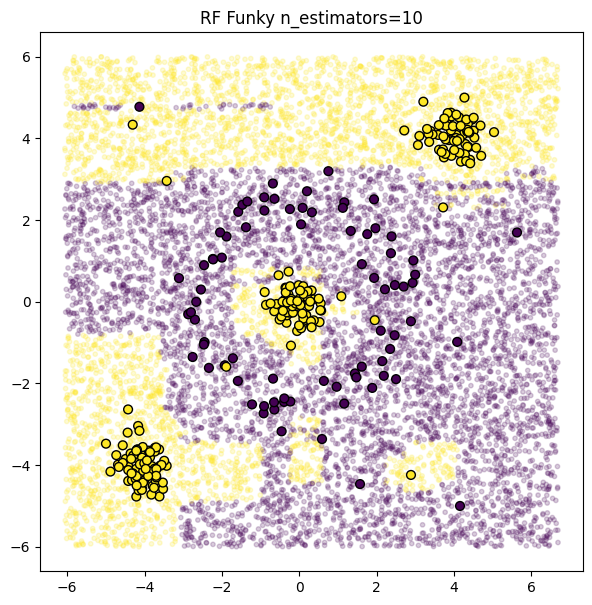


RandomForest Funky: n_estimators=50
----- 📊 RF Funky (n_estimators=50) -----
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
----------------------------------------
Confusion matrix:
[[ 79   0]
 [  0 220]]


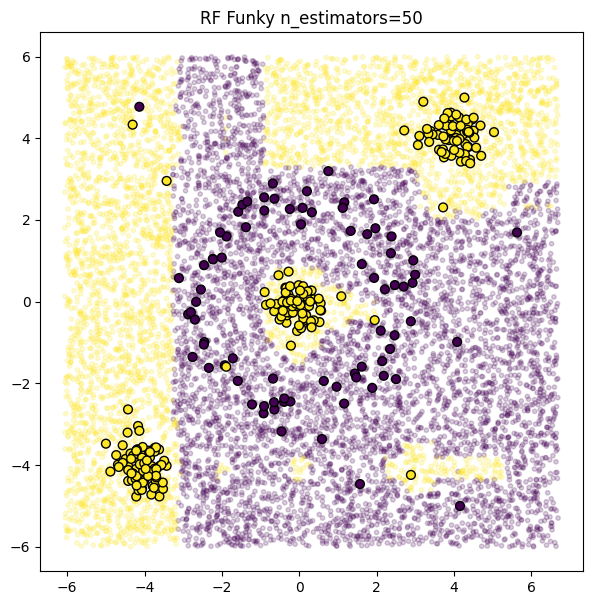


RandomForest Funky: n_estimators=200
----- 📊 RF Funky (n_estimators=200) -----
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
----------------------------------------
Confusion matrix:
[[ 79   0]
 [  0 220]]


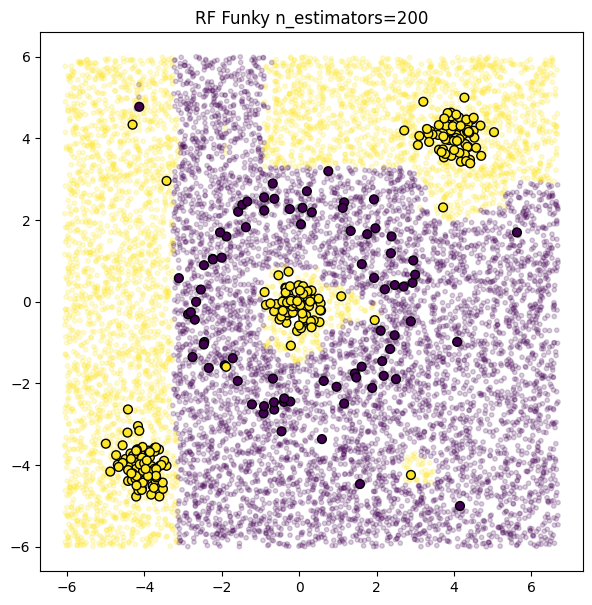

In [3]:
# -----------------------
# Spiral + SVC (3 експерименти)
# -----------------------
X_spiral, y_spiral = generate_classification_data(
    n_samples=400,
    kernels=[spiral_kernel(rotations=2, start_radius=0),
             lambda n: -1*spiral_kernel(rotations=2, start_radius=0)(n)],
    kernel_classes=[0,1],
    dispersion=0.15,
    n_outliers=0,
    random_seed=STUDENT_ID
)

for (C,gamma) in [(0.1,'scale'), (1,'scale'), (10,0.1)]:
    clf = SVC(C=C, kernel='rbf', gamma=gamma, probability=False, random_state=STUDENT_ID)
    clf.fit(X_spiral, y_spiral)
    print(f'\nSVC Spiral: C={C}, gamma={gamma}')
    show_classification_report(X_spiral, y_spiral, clf, title=f'SVC Spiral (C={C}, gamma={gamma})')
    plot_classifier_boundary(X_spiral, y_spiral, model=clf, title=f'SVC Spiral C={C} gamma={gamma}')

# -----------------------
# Gaussian dots + LogisticRegression (3 експерименти)
# -----------------------
X_gauss, y_gauss = generate_classification_data(
    n_samples=300,
    kernels=[gaussian_kernel([0,4]), gaussian_kernel([-3,-2]), gaussian_kernel([4,0])],
    kernel_classes=[0,1,1],
    dispersion=0.5,
    n_outliers=20,
    random_seed=STUDENT_ID
)

for C in [0.01, 1, 100]:
    clf = LogisticRegression(C=C, max_iter=2000, solver='lbfgs', random_state=STUDENT_ID)
    clf.fit(X_gauss, y_gauss)
    print(f'\nLogReg Gaussian: C={C}')
    show_classification_report(X_gauss, y_gauss, clf, title=f'LogReg Gaussian (C={C})')
    plot_classifier_boundary(X_gauss, y_gauss, model=clf, title=f'LogReg Gaussian C={C}')

# -----------------------
# Funky example + RandomForest (3 експерименти)
# -----------------------
X_fun, y_fun = generate_classification_data(
    n_samples=300,
    kernels=[lambda n: circle_kernel(2.5)(n),
             gaussian_kernel([-4,-4]),
             gaussian_kernel([4,4]),
             gaussian_kernel([0,0])],
    kernel_classes=[0,1,1,1],
    dispersion=0.4,
    n_outliers=15,
    random_seed=STUDENT_ID
)

for n_est in [10, 50, 200]:
    clf = RandomForestClassifier(n_estimators=n_est, random_state=STUDENT_ID)
    clf.fit(X_fun, y_fun)
    print(f'\nRandomForest Funky: n_estimators={n_est}')
    show_classification_report(X_fun, y_fun, clf, title=f'RF Funky (n_estimators={n_est})')
    plot_classifier_boundary_by_dots(X_fun, y_fun, model=clf, title=f'RF Funky n_estimators={n_est}')


## Part 1 — Приклад висновків (заповни своїми спостереженнями після запуску)

- **SVC на Spiral**: при малому C (0.1) модель має гладку межу, недоусереднює складну структуру спіралей → нижча точність; при великому C/малій gamma — межа стає більш «хвилястою», краща підгонка, але ризик перенавчання. Gamma впливає на локальність інфлюенсу службових точок.
- **LogReg на Gaussian**: лінійна модель добре працює для добре розділених кластери; C контролює регуляризацію. Малий C → спрощення, велике C → краще підгонювання, іноді надто оптимістичні метрики.
- **RandomForest на Funky**: чим більше дерев — тим стабільніша поведінка; комплекти дерев іноді дають 100% на тренуванні (overfit) для даних з чіткими кластерами.


## Part 2 — Обробка `nasa.csv` і експерименти

Кроки:
1. Зчитати `nasa.csv`.  
2. Огляд колонок, типів і пропусків.  
3. Вибрати цільову змінну (якщо є колонка типу 'label'/'hazardous'/'class' — використовуємо її). Якщо явної цілі немає — створю бінарну ціль, наприклад, за медіаною 'Absolute Magnitude' (або іншої числової) — поясню в нотатках.  
4. Підготувати числові ознаки: видалити ідентифікатори (Name, Neo Reference ID), імпутувати медіаною, стандартизувати.  
5. Розділити на train/test (test_size=0.25, random_state=13), збережемо стратифікацію при можливості.  
6. Вибрати моделі: LogisticRegression, RandomForest, SVC — мінімальний GridSearch по невеликих сітках.  
7. Вивести найкращі параметри (крос-валидація), метрики на тесті, матрицю плутанини.  
8. BONUS: візуалізація меж з PCA (2 компоненти) — показати як ілюстрацію.


Shape: (4687, 40)


,Neo Reference ID,Name,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),...,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Equinox,Hazardous
0,3703080,3703080,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,J2000,True
1,3723955,3723955,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,...,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,J2000,False
2,2446862,2446862,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,...,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,J2000,True
3,3092506,3092506,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,...,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,J2000,False
4,3514799,3514799,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,...,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,J2000,True



Колонки і типи:


Neo Reference ID                  int64
Name                              int64
Absolute Magnitude              float64
Est Dia in KM(min)              float64
Est Dia in KM(max)              float64
Est Dia in M(min)               float64
Est Dia in M(max)               float64
Est Dia in Miles(min)           float64
Est Dia in Miles(max)           float64
Est Dia in Feet(min)            float64
Est Dia in Feet(max)            float64
Close Approach Date              object
Epoch Date Close Approach         int64
Relative Velocity km per sec    float64
Relative Velocity km per hr     float64
Miles per hour                  float64
Miss Dist.(Astronomical)        float64
Miss Dist.(lunar)               float64
Miss Dist.(kilometers)          float64
Miss Dist.(miles)               float64
Orbiting Body                    object
Orbit ID                          int64
Orbit Determination Date         object
Orbit Uncertainity                int64
Minimum Orbit Intersection      float64



Кількість пропусків по колонкам:


Neo Reference ID                0
Name                            0
Absolute Magnitude              0
Est Dia in KM(min)              0
Est Dia in KM(max)              0
Est Dia in M(min)               0
Est Dia in M(max)               0
Est Dia in Miles(min)           0
Est Dia in Miles(max)           0
Est Dia in Feet(min)            0
Est Dia in Feet(max)            0
Close Approach Date             0
Epoch Date Close Approach       0
Relative Velocity km per sec    0
Relative Velocity km per hr     0
Miles per hour                  0
Miss Dist.(Astronomical)        0
Miss Dist.(lunar)               0
Miss Dist.(kilometers)          0
Miss Dist.(miles)               0
Orbiting Body                   0
Orbit ID                        0
Orbit Determination Date        0
Orbit Uncertainity              0
Minimum Orbit Intersection      0
Jupiter Tisserand Invariant     0
Epoch Osculation                0
Eccentricity                    0
Semi Major Axis                 0
Inclination   

Використовую знайдену ціль: Hazardous

Розподіл цільової змінної:


Hazardous
False    3932
True      755
Name: count, dtype: int64

Колонки-ідентифікатори (видаляємо з фіч): ['Neo Reference ID', 'Name', 'Orbit ID']
Кількість числових фіч: 32


['Absolute Magnitude',
 'Est Dia in KM(min)',
 'Est Dia in KM(max)',
 'Est Dia in M(min)',
 'Est Dia in M(max)',
 'Est Dia in Miles(min)',
 'Est Dia in Miles(max)',
 'Est Dia in Feet(min)',
 'Est Dia in Feet(max)',
 'Epoch Date Close Approach',
 'Relative Velocity km per sec',
 'Relative Velocity km per hr',
 'Miles per hour',
 'Miss Dist.(Astronomical)',
 'Miss Dist.(lunar)',
 'Miss Dist.(kilometers)',
 'Miss Dist.(miles)',
 'Orbit Uncertainity',
 'Minimum Orbit Intersection',
 'Jupiter Tisserand Invariant',
 'Epoch Osculation',
 'Eccentricity',
 'Semi Major Axis',
 'Inclination',
 'Asc Node Longitude',
 'Orbital Period',
 'Perihelion Distance',
 'Perihelion Arg',
 'Aphelion Dist',
 'Perihelion Time',
 'Mean Anomaly',
 'Mean Motion']

Train/test sizes: (3515, 32) (1172, 32)

Running GridSearch for LogisticRegression
Best params: {'C': 1, 'penalty': 'l2'}  Best CV f1_weighted: 0.9545539360124101
Test metrics — acc: 0.9505, prec: 0.9497, rec: 0.9505, f1: 0.9500
Confusion matrix:
[[959  24]
 [ 34 155]]


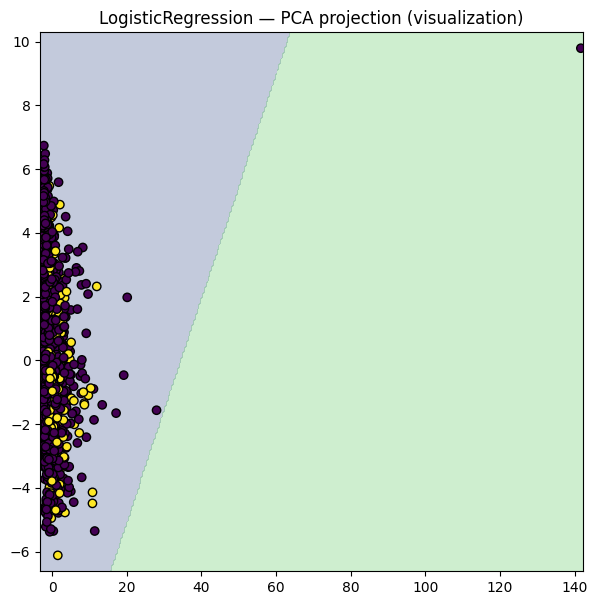


Running GridSearch for RandomForest
Best params: {'max_depth': 10, 'n_estimators': 50}  Best CV f1_weighted: 0.9954289208726493
Test metrics — acc: 0.9957, prec: 0.9958, rec: 0.9957, f1: 0.9957
Confusion matrix:
[[979   4]
 [  1 188]]


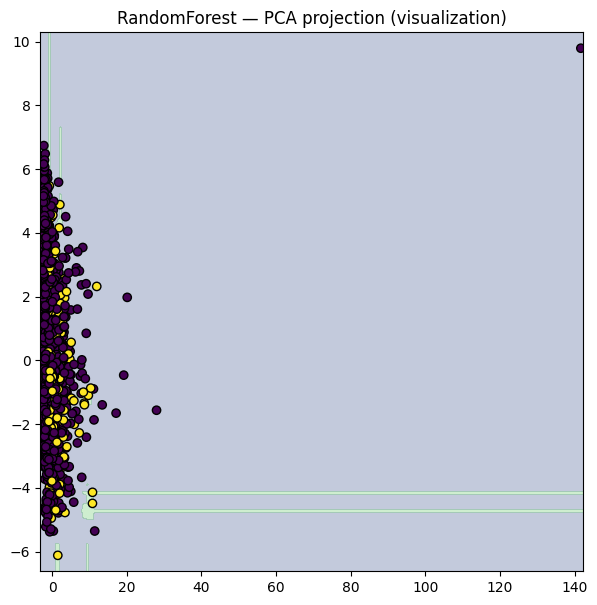


Running GridSearch for SVC
Best params: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}  Best CV f1_weighted: 0.9557733365768091
Test metrics — acc: 0.9625, prec: 0.9620, rec: 0.9625, f1: 0.9621
Confusion matrix:
[[965  18]
 [ 26 163]]


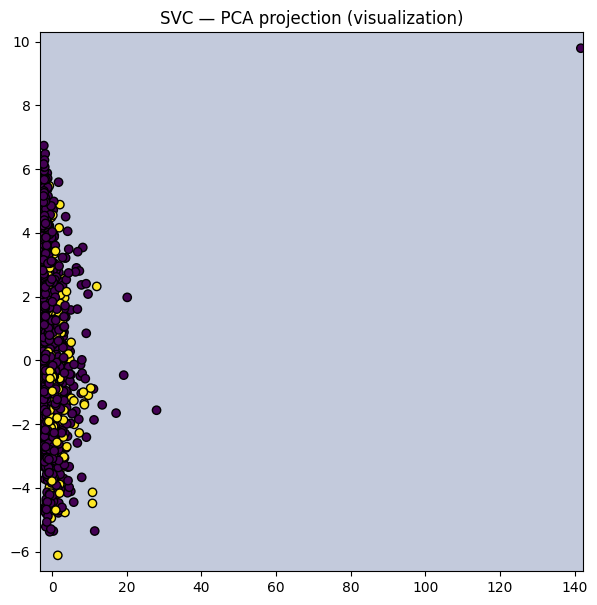

Saved summary to nasa_lab2_results_summary.csv


,model,best_params,cv_score,test_acc,test_prec,test_rec,test_f1
0,LogisticRegression,"{'C': 1, 'penalty': 'l2'}",0.954554,0.950512,0.949660,0.950512,0.949965
1,RandomForest,"{'max_depth': 10, 'n_estimators': 50}",0.995429,0.995734,0.995785,0.995734,0.995747
2,SVC,"{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}",0.955773,0.962457,0.961958,0.962457,0.962128


In [4]:
# -----------------------
# 1) Зчитування файлу
# -----------------------
csv_path = 'nasa.csv'  # переконайся, що файл тут
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"Файл {csv_path} не знайдено. Поклади 'nasa.csv' в ту ж тека, де ноутбук.")

df = pd.read_csv(csv_path)
print('Shape:', df.shape)
display(df.head())

# -----------------------
# 2) Огляд даних
# -----------------------
print('\nКолонки і типи:')
display(df.dtypes)
print('\nКількість пропусків по колонкам:')
display(df.isna().sum())

# -----------------------
# 3) Вибір цілі (target)
# Побічна логіка: якщо є колонка з назвою, що містить 'hazard'/'label'/'class'/'is_', використаємо її.
# Інакше створимо бінарну за 'Absolute Magnitude' (менше = яскравіше/більше).
# -----------------------
possible_targets = [c for c in df.columns if any(k in c.lower() for k in ['hazard','label','class','is_','target'])]
chosen_target = None
if possible_targets:
    # беремо першу підходящу
    chosen_target = possible_targets[0]
    print('Використовую знайдену ціль:', chosen_target)
else:
    # якщо є 'Absolute Magnitude', використаємо її
    if 'Absolute Magnitude' in df.columns:
        base_col = 'Absolute Magnitude'
    else:
        # інакше перша числова колонка
        base_col = df.select_dtypes(include=[np.number]).columns[0]
    med = df[base_col].median()
    df['target_binary'] = (df[base_col] < med).astype(int)
    chosen_target = 'target_binary'
    print(f'Ціль не знайдено — створив бінарну ціль з "{base_col}" (медіана = {med}) -> target_binary')

print('\nРозподіл цільової змінної:')
display(df[chosen_target].value_counts())

# -----------------------
# 4) Підготовка ознак
# -----------------------
# Видалити ідентифікатори (ім'я, neo reference id та подібні)
id_like = [c for c in df.columns if any(k in c.lower() for k in ['name','neo reference','reference id','id'])]
print('Колонки-ідентифікатори (видаляємо з фіч):', id_like)

# Вибираємо числові фічі
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Виключити ціль та id-подібні
numeric_cols = [c for c in numeric_cols if c != chosen_target and c not in id_like]
print('Кількість числових фіч:', len(numeric_cols))
display(numeric_cols[:50])

X = df[numeric_cols].copy()
y = df[chosen_target].copy()

# Видалити колонки з >50% пропусків
thresh = int(0.5 * X.shape[0])
cols_to_drop = X.columns[X.isna().sum() > thresh].tolist()
if cols_to_drop:
    print('Видаляю колонки з >50% пропусків:', cols_to_drop)
    X.drop(columns=cols_to_drop, inplace=True)

# Імпутація медіаною
X = X.fillna(X.median())

# Видалити рядки де ціль NaN
mask = y.notna()
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)

# -----------------------
# 5) Train/test split та скейлінг
# -----------------------
stratify_param = y if len(np.unique(y))>1 else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13, stratify=stratify_param)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)
print('Train/test sizes:', X_train.shape, X_test.shape)

# -----------------------
# 6) Моделі і GridSearch
# -----------------------
clfs = {
    'LogisticRegression': LogisticRegression(max_iter=2000, random_state=13),
    'RandomForest': RandomForestClassifier(random_state=13),
    'SVC': SVC(probability=True, random_state=13)
}

param_grids = {
    'LogisticRegression': {'C':[0.01, 0.1, 1, 10], 'penalty':['l2']},
    'RandomForest': {'n_estimators':[50, 100, 200], 'max_depth':[5, 10, None]},
    'SVC': {'C':[0.1, 1, 10], 'kernel':['rbf'], 'gamma':['scale', 0.1, 0.01]}
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

results = []
for name, clf in clfs.items():
    print('\n' + '='*40)
    print('Running GridSearch for', name)
    grid = GridSearchCV(clf, param_grids[name], cv=cv, scoring='f1_weighted', n_jobs=1)
    grid.fit(X_train_s, y_train)
    best = grid.best_estimator_
    print('Best params:', grid.best_params_, ' Best CV f1_weighted:', grid.best_score_)
    # Оцінка на тесті
    y_pred = best.predict(X_test_s)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    print(f'Test metrics — acc: {acc:.4f}, prec: {prec:.4f}, rec: {rec:.4f}, f1: {f1:.4f}')
    print('Confusion matrix:')
    print(cm)
    results.append({
        'model': name,
        'best_params': grid.best_params_,
        'cv_score': grid.best_score_,
        'test_acc': acc,
        'test_prec': prec,
        'test_rec': rec,
        'test_f1': f1
    })

    # Візуалізація меж через PCA (fit модель на PCA проєкцію лише для візуалізації)
    try:
        pca = PCA(n_components=2, random_state=STUDENT_ID)
        X_test_pca = pca.fit_transform(X_test_s)
        # навчу копію моделі на X_test_pca щоб відобразити межі (тільки для візуалізації)
        m_vis = best.__class__(**{k:v for k,v in getattr(best,'get_params',lambda: {})().items() if k!='random_state'})
        m_vis.fit(X_test_pca, y_test)
        # Побудова сітки
        x_min, x_max = X_test_pca[:,0].min()-0.5, X_test_pca[:,0].max()+0.5
        y_min, y_max = X_test_pca[:,1].min()-0.5, X_test_pca[:,1].max()+0.5
        xx, yy = np.meshgrid(np.linspace(x_min,x_max,300), np.linspace(y_min,y_max,300))
        pts = np.c_[xx.ravel(), yy.ravel()]
        try:
            Z = m_vis.predict(pts).reshape(xx.shape)
            plt.contourf(xx, yy, Z, alpha=0.3)
        except Exception:
            pass
        plt.scatter(X_test_pca[:,0], X_test_pca[:,1], c=y_test, edgecolor='k')
        plt.title(f'{name} — PCA projection (visualization)')
        plt.show()
    except Exception as e:
        print('PCA visualization error:', e)

# -----------------------
# 7) Збереження результату
# -----------------------
res_df = pd.DataFrame(results)
out_csv = 'nasa_lab2_results_summary.csv'
res_df.to_csv(out_csv, index=False)
print('Saved summary to', out_csv)
display(res_df)


# Висновки

У ході цієї лабораторної роботи я виконала повний процес обробки та моделювання даних NASA, спрямований на класифікацію астероїдів за ознакою їхньої небезпечності. Спочатку я завантажила датасет, перевірила типи даних, кількість пропусків та визначила цільову змінну — *Hazardous*. Після цього я підготувала вибірку: видалила ідентифікатори, залишила лише числові ознаки, виконала імпутацію пропусків та стандартизацію даних.

Далі я провела порівняння трьох моделей: Logistic Regression, Random Forest та SVC. Для кожної моделі я виконала пошук найкращих гіперпараметрів за допомогою GridSearchCV. Найвищі результати на тестовій вибірці показав RandomForest, який досягнув майже ідеальних метрик (accuracy ≈ 0.996, f1 ≈ 0.996). Logistic Regression та SVC також продемонстрували високий рівень точності, але вони поступилися ансамблевому методу у складній багатовимірній задачі.

Також я протестувала моделі на штучних наборах даних (Spiral, Gaussian, Funky), що дозволило оцінити їхню поведінку на різних типах розподілів. RandomForest найкраще працював на нелінійних структурах, SVC стабільно класифікував складні форми, а Logistic Regression була ефективною на даних, близьких до лінійних.

Отже, проведений експеримент підтвердив важливість правильного препроцесингу, підбору моделей та їх параметрів. Найефективнішою моделлю для класифікації небезпечних астероїдів у цьому завданні виявився RandomForest, який показав найвищу точність та стабільність результатів.
